In [ ]:
#matplotlib 한글깨짐방지
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
#xls 읽기 위해
!pip install xlrd==1.2.0 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns

# DACON - 6조

## 주제  
**<font color=#5F71F7> '서울시의 교통혼잡도 및 비용부담 증가 개선 방향 제시' </font>**

## 개요  
###  1. 현황 분석 및 현재 문제 해결의 중요성
###  2. 대안 제시 및 검증, 분석
###  3. 대안의 예측 결과 또는 예상 효과 파악
###  4. 결론

---

### 1. 서울지하철역 아침/저녁 이용자수 Top10 (+우대권 이용자수 Top10)

In [2]:
def read_df(y, m, sheet=2): #sheet 2는 월별 무임유임 승하차 데이터, sheet3은 일별시간별 승하차데이터
  rootdir = '/content/drive/MyDrive/DACON6/지하철 이용 정보/교통카드 통계자료' #승하차 데이터 루트 경로

  sub_dirs = {} #sub_dirs[year][month]로 해당 월의 xls 파일경로를 가져올 수 있도록 딕셔너리 만듦.
  for year in os.listdir(rootdir):
    sub_sub_dirs = {}
    for month in os.listdir(os.path.join(rootdir, year)):
      sub_sub_dirs[int(month.split(' ')[1][:2])] = os.path.join(rootdir, year, month)
    sub_dirs[int(year)] = sub_sub_dirs

  df = pd.read_excel(sub_dirs[y][m], sheet_name=sheet, thousands=',')

  if sheet==2:
    df = df.drop(columns=['호선명', '역ID', '작업일시', '사용월'])
    df = df.groupby(by='지하철역').sum()
    df['지하철역'] = df.index
    df.index = list(range(len(df)))
  if sheet==3:
    df = df.iloc[1:, 3:-1]
    c = ['지하철역']
    for i in range(24):
      c.append(f'{(i+3)%24}시승차')
      c.append(f'{(i+3)%24}시하차')
    df.columns = c
    temp = df['지하철역']
    df = df[df.columns[1:]].astype('int')
    df['지하철역'] = temp
    df = df.groupby(by='지하철역').sum()
    df['지하철역'] = df.index
    df.index = list(range(len(df)))
  return df


####아침/저녁 전체이용 Top 10 (승하차)

In [3]:
#시간대별 전체 승하차
df = read_df(2022, 5, 3)

time_dict = {'아침승차':['7시승차', '8시승차'], '아침하차':['7시하차', '8시하차'], '점심승차':['14시승차','15시승차'], '점심하차':['14시하차','15시하차'], '저녁승차':['18시승차', '19시승차'], '저녁하차':['18시하차', '19시하차']}
for s in ['아침승차', '아침하차', '점심승차', '점심하차', '저녁승차', '저녁하차']:
  df[s] = df[time_dict[s]].mean(axis=1)

#아침승하차, 저녁승하차  
df2=df[['아침승차','아침하차','저녁승차','저녁하차']].astype(int)
df2.insert(0,'지하철역',df['지하철역'])
df2['아침승하차']=df2['아침승차']+df2['아침하차']
df2['저녁승하차']=df2['저녁승차']+df2['저녁하차']

In [4]:
#아침승하차, 저녁승하차 합계만
df2 = df2.drop(columns=['아침승차', '아침하차', '저녁승차', '저녁하차'])

In [ ]:
#아침승하차 순위
df2_am=(df2
        .drop(columns=['저녁승하차'])
        .sort_values('아침승하차',ascending=False)
        .reset_index(drop=True)
        .iloc[:10]
        )
df2_am

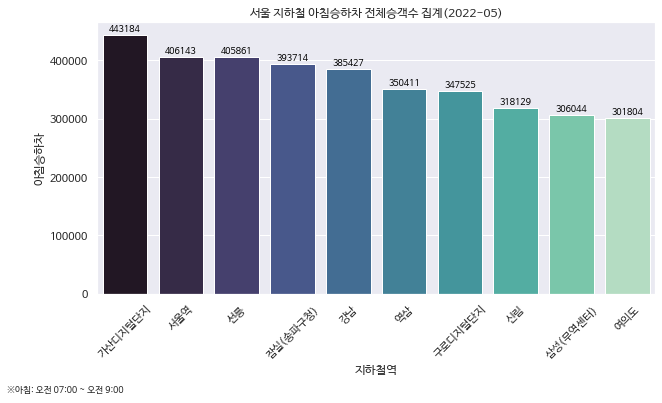

In [6]:
sns.set(rc={"figure.figsize":(10, 5)})
plt.rc('font', family='NanumBarunGothic') 
x=df2_am['지하철역']
y=df2_am['아침승하차']
sns.barplot(x=x,y=y,palette="mako").set(title='서울 지하철 아침승하차 전체승객수 집계(2022-05)')
plt.xticks(rotation=45)
plt.figtext(0, -0.15, '※아침: 오전 07:00 ~ 오전 9:00', fontSize=9)
#수치값 표시
for i, v in enumerate(df2_am.index):
    plt.text(v, y[i], y[i],                
             fontsize = 9, 
             color='black',
             horizontalalignment='center', 
             verticalalignment='bottom')

plt.show()

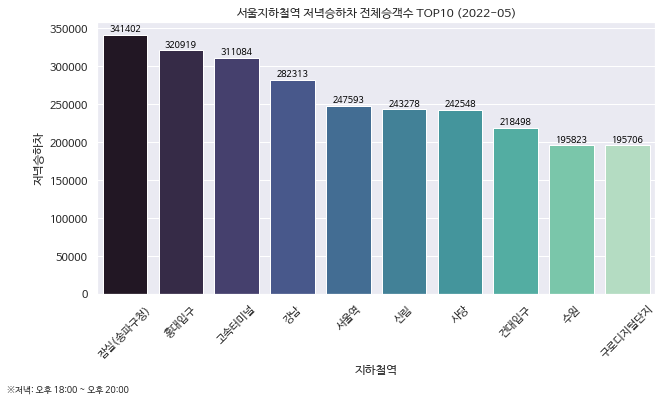

In [7]:
#저녁승하차 순위
df2_pm=(df2
        .drop(columns=['아침승하차'])
        .sort_values('저녁승하차',ascending=False)
        .reset_index(drop=True)
        .iloc[:10]
        )
sns.set(rc={"figure.figsize":(10, 5)})
plt.rc('font', family='NanumBarunGothic') 
x=df2_pm['지하철역']
y=df2_pm['저녁승하차']
sns.barplot(x=x,y=y,palette="mako").set(title='서울지하철역 저녁승하차 전체승객수 TOP10 (2022-05)')
plt.figtext(0, -0.15, '※저녁: 오후 18:00 ~ 오후 20:00', fontSize=9)
plt.xticks(rotation=45)
#수치값 표시
for i, v in enumerate(df2_pm.index):
    plt.text(v, y[i], y[i],                
             fontsize = 9, 
             color='black',
             horizontalalignment='center', 
             verticalalignment='bottom')
plt.show()

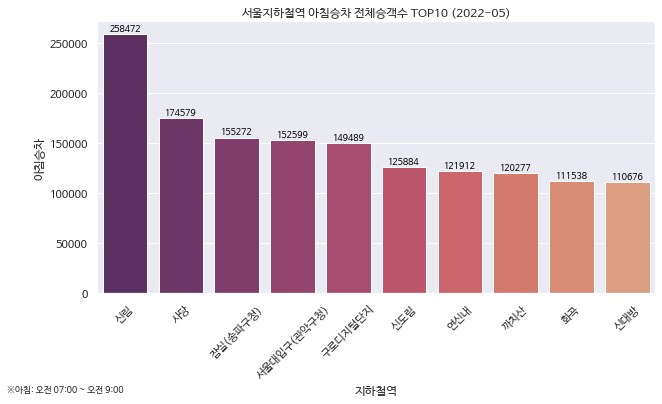

In [8]:
#아침승차
df2_am_on=(df[['지하철역','아침승차']]
        .sort_values('아침승차',ascending=False)
        .reset_index(drop=True)
        .iloc[:10]
        )
df2_am_on['아침승차']=df2_am_on['아침승차'].astype(int)
sns.set(rc={"figure.figsize":(10, 5)})
plt.rc('font', family='NanumBarunGothic')
x=df2_am_on['지하철역']
y=df2_am_on['아침승차']

#색상선택
palette = sns.color_palette("flare",n_colors=10)
palette.reverse() 
p=sns.barplot(x=x,y=y,data=df2_am_on,palette=palette).set(title='서울지하철역 아침승차 전체승객수 TOP10 (2022-05)')
plt.figtext(0, -0.15, '※아침: 오전 07:00 ~ 오전 9:00', fontSize=9)
plt.xticks(rotation=45)
#수치값 표시
for i, v in enumerate(df2_am_on.index):
    plt.text(v, y[i], y[i],                
             fontsize = 9, 
             color='black',
             horizontalalignment='center', 
             verticalalignment='bottom')
plt.show()


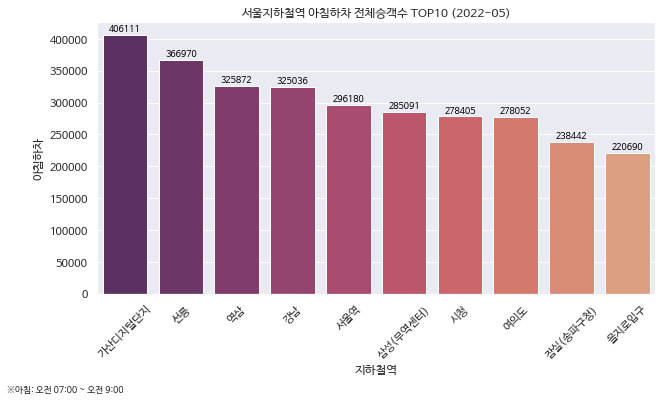

In [9]:
#아침하차
df2_am_off=(df[['지하철역','아침하차']]
        .sort_values('아침하차',ascending=False)
        .reset_index(drop=True)
        .iloc[:10]
        )
df2_am_off['아침하차']=df2_am_off['아침하차'].astype(int)
sns.set(rc={"figure.figsize":(10, 5)})
plt.rc('font', family='NanumBarunGothic') 
x=df2_am_off['지하철역']
y=df2_am_off['아침하차']

#색상선택
palette = sns.color_palette("flare",n_colors=10)
palette.reverse() 
sns.barplot(x=x,y=y,data=df2_am_on,palette=palette).set(title='서울지하철역 아침하차 전체승객수 TOP10 (2022-05)')
plt.figtext(0, -0.15, '※아침: 오전 07:00 ~ 오전 9:00', fontSize=9)
plt.xticks(rotation=45)

#수치값 표시
for i, v in enumerate(df2_am_off.index):
    plt.text(v, y[i], y[i],                
             fontsize = 9, 
             color='black',
             horizontalalignment='center', 
             verticalalignment='bottom')
plt.show()

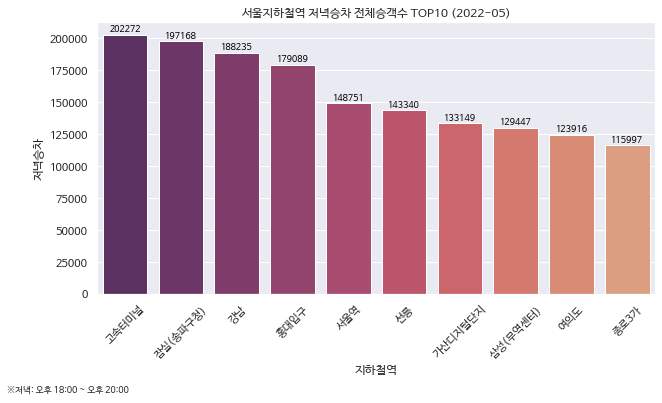

In [10]:
#저녁승차
df2_pm_on=(df[['지하철역','저녁승차']]
        .sort_values('저녁승차',ascending=False)
        .reset_index(drop=True)
        .iloc[:10]
        )
df2_pm_on['저녁승차']=df2_pm_on['저녁승차'].astype(int)
sns.set(rc={"figure.figsize":(10, 5)})
plt.rc('font', family='NanumBarunGothic') 
x=df2_pm_on['지하철역']
y=df2_pm_on['저녁승차']

#색상선택
palette = sns.color_palette("flare",n_colors=10)
palette.reverse() 
sns.barplot(x=x,y=y,data=df2_am_on,palette=palette).set(title='서울지하철역 저녁승차 전체승객수 TOP10 (2022-05)')
plt.figtext(0, -0.15, '※저녁: 오후 18:00 ~ 오후 20:00', fontSize=9)
plt.xticks(rotation=45)
#수치값 추가
for i, v in enumerate(df2_pm_on.index):
    plt.text(v, y[i], y[i],                 
             fontsize = 9, 
             color='black',
             horizontalalignment='center', 
             verticalalignment='bottom')   
plt.show()

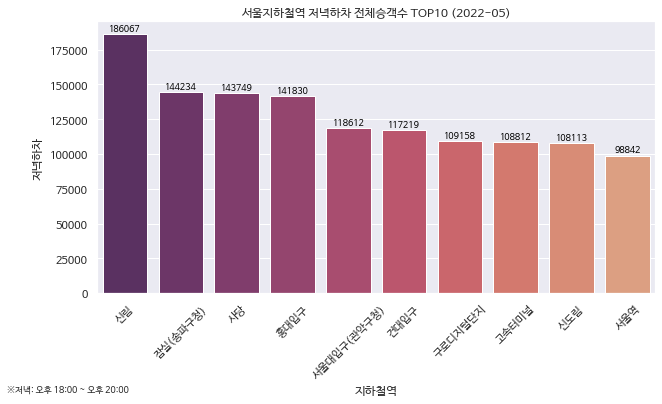

In [11]:
df2_pm_off=(df[['지하철역','저녁하차']]
        .sort_values('저녁하차',ascending=False)
        .reset_index(drop=True)
        .iloc[:10]
        )
df2_pm_off['저녁하차']=df2_pm_off['저녁하차'].astype(int)
sns.set(rc={"figure.figsize":(10, 5)})
plt.rc('font', family='NanumBarunGothic') 
x=df2_pm_off['지하철역']
y=df2_pm_off['저녁하차']

#색상선택
palette = sns.color_palette("flare",n_colors=10)
palette.reverse() 
sns.barplot(x=x,y=y,data=df2_am_on,palette=palette).set(title='서울지하철역 저녁하차 전체승객수 TOP10 (2022-05)')
plt.figtext(0, -0.15, '※저녁: 오후 18:00 ~ 오후 20:00', fontSize=9)
#텍스트 회전
plt.xticks(rotation=45)
#수치값 추가
for i, v in enumerate(df2_pm_on.index):
    plt.text(v, y[i], y[i],                 
             fontsize = 9, 
             color='black',
             horizontalalignment='center', 
             verticalalignment='bottom')  
plt.show()

####아침/저녁 노인이용 Top10 (승하차)

In [ ]:
df3=pd.read_csv('/content/drive/MyDrive/DACON6/지하철 이용 정보/서울교통공사_역별 일별 시간대별 노인 승하차인원 정보_20220531.csv',encoding='cp949')
df3.head()

In [13]:
#월단위로 추출하기 위해 date 타입으로 바꿔줌
df3['일자'] = pd.to_datetime(df3['일자'])

In [14]:
#5월 데이터 추출
query_month = 5 
filtered = df3.query('일자.dt.month == @query_month')
#아침승하차, 저녁승하차 합계
filtered =filtered[['역명','07시-08시','08시-09시','18시-19시','19시-20시']]
filtered= filtered.groupby(filtered['역명']).sum()
filtered.reset_index(level=['역명'], inplace = True)
filtered['아침승하차']=filtered['07시-08시']+filtered['08시-09시']
filtered['저녁승하차']=filtered['18시-19시']+filtered['19시-20시']
filtered=filtered.drop(columns=['07시-08시','08시-09시','18시-19시','19시-20시'])

In [15]:
#노인 아침승하차
df3_am=(filtered
        .drop(columns=['저녁승하차'])
        .sort_values('아침승하차',ascending=False)
        .iloc[:10]
        )
df3_am['아침승하차']=df3_am['아침승하차'].astype(int)
df3_am=df3_am.reset_index(drop=True)

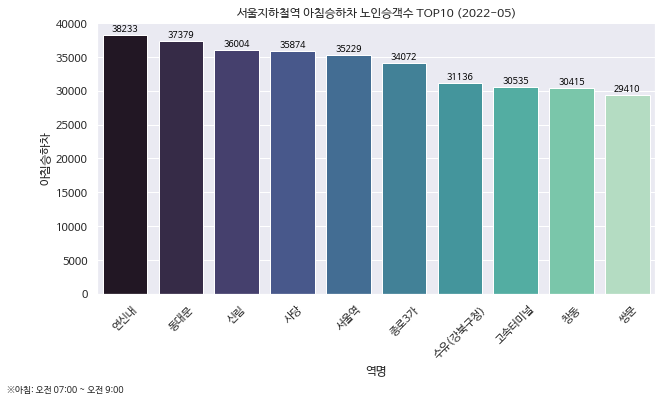

In [16]:
sns.set(rc={"figure.figsize":(10, 5)})
plt.rc('font', family='NanumBarunGothic') 
x=df3_am['역명']
y=df3_am['아침승하차']
sns.barplot(x=x,y=y,palette="mako").set(title='서울지하철역 아침승하차 노인승객수 TOP10 (2022-05)')
plt.figtext(0, -0.15, '※아침: 오전 07:00 ~ 오전 9:00', fontSize=9)

#텍스트 회전
plt.xticks(rotation=45)

#수치값 추가
for i, v in enumerate(df3_am.index):
    plt.text(v, y[i], y[i],                 
             fontsize = 9, 
             color='black',
             horizontalalignment='center', 
             verticalalignment='bottom') 

plt.show()

In [ ]:
#노인 저녁
df3_pm=(filtered
        .drop(columns=['아침승하차'])
        .sort_values('저녁승하차',ascending=False)
        .iloc[:10]
        )
df3_pm['저녁승하차']=df3_pm['저녁승하차'].astype(int)
df3_pm=df3_pm.reset_index(drop=True)

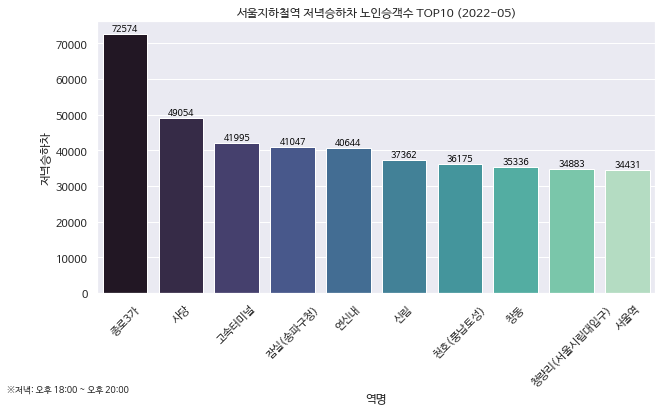

In [18]:
sns.set(rc={"figure.figsize":(10, 5)})
plt.rc('font', family='NanumBarunGothic') 
x=df3_pm['역명']
y=df3_pm['저녁승하차']
sns.barplot(x=x,y=y,palette="mako").set(title='서울지하철역 저녁승하차 노인승객수 TOP10 (2022-05)')
plt.figtext(0, -0.15, '※저녁: 오후 18:00 ~ 오후 20:00', fontSize=9)
#텍스트 회전
plt.xticks(rotation=45)
#수치값 추가
for i, v in enumerate(df3_pm.index):
    plt.text(v, y[i], y[i],                 
             fontsize = 9, 
             color='black',
             horizontalalignment='center', 
             verticalalignment='bottom') 

plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


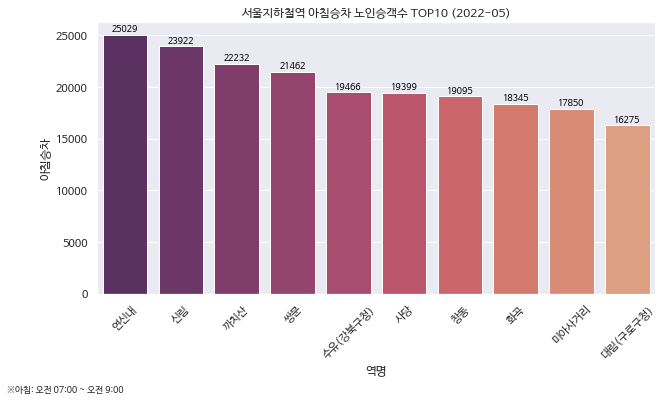

In [19]:
#5월 데이터 추출
query_month = 5 
df3_onoff = df3.query('일자.dt.month == @query_month')

#승차데이터만 추출
df3_on=df3_onoff[df3_onoff['구분']=='합계 : 승차']

#아침승차
df3_am_on =df3_on[['역명','07시-08시','08시-09시']]
df3_am_on['아침승차']=df3_am_on['07시-08시']+df3_am_on['08시-09시']
df3_am_on=df3_am_on.drop(columns=['07시-08시','08시-09시'])
df3_am_on= df3_am_on.groupby(df3_am_on['역명']).sum()

#아침승차 top10
df3_am_on=(df3_am_on
        .sort_values('아침승차',ascending=False)
        .reset_index()
        .iloc[:10]
        )
df3_am_on['아침승차']=df3_am_on['아침승차'].astype(int)

#시각화
sns.set(rc={"figure.figsize":(10, 5)})
plt.rc('font', family='NanumBarunGothic')
x=df3_am_on['역명']
y=df3_am_on['아침승차']

#색상선택
palette = sns.color_palette("flare",n_colors=10)
palette.reverse() 
p=sns.barplot(x=x,y=y,data=df3_am_on,palette=palette).set(title='서울지하철역 아침승차 노인승객수 TOP10 (2022-05)')
plt.figtext(0, -0.15, '※아침: 오전 07:00 ~ 오전 9:00', fontSize=9)
#텍스트 회전
plt.xticks(rotation=45)
#수치값 표시
for i, v in enumerate(df3_am_on.index):
    plt.text(v, y[i], y[i],                
             fontsize = 9, 
             color='black',
             horizontalalignment='center', 
             verticalalignment='bottom')
plt.show()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


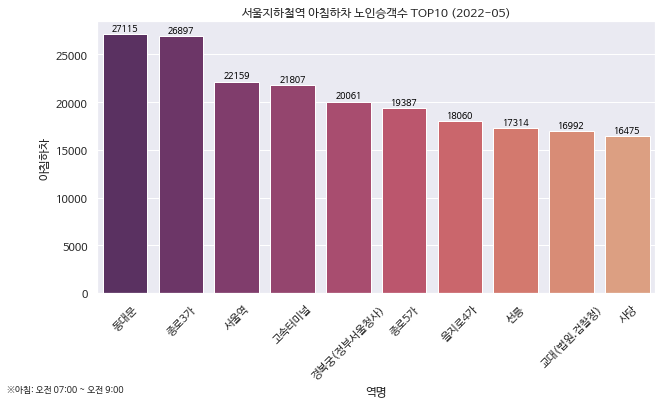

In [20]:
#하차데이터만 추출
df3_off=df3_onoff[df3_onoff['구분']=='합계 : 하차']

#아침하차
df3_am_off =df3_off[['역명','07시-08시','08시-09시']]
df3_am_off['아침하차']=df3_am_off['07시-08시']+df3_am_off['08시-09시']
df3_am_off=df3_am_off.drop(columns=['07시-08시','08시-09시'])
df3_am_off= df3_am_off.groupby(df3_am_off['역명']).sum()

#아침하차 top10
df3_am_off=(df3_am_off
        .sort_values('아침하차',ascending=False)
        .reset_index()
        .iloc[:10]
        )
df3_am_off['아침하차']=df3_am_off['아침하차'].astype(int)

#시각화
sns.set(rc={"figure.figsize":(10, 5)})
plt.rc('font', family='NanumBarunGothic')
x=df3_am_off['역명']
y=df3_am_off['아침하차']

#색상선택
palette = sns.color_palette("flare",n_colors=10)
palette.reverse() 
p=sns.barplot(x=x,y=y,data=df3_am_off,palette=palette).set(title='서울지하철역 아침하차 노인승객수 TOP10 (2022-05)')
plt.figtext(0, -0.15, '※아침: 오전 07:00 ~ 오전 9:00', fontSize=9)
#텍스트 회전
plt.xticks(rotation=45)
#수치값 표시
for i, v in enumerate(df3_am_off.index):
    plt.text(v, y[i], y[i],                
             fontsize = 9, 
             color='black',
             horizontalalignment='center', 
             verticalalignment='bottom')
plt.show()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


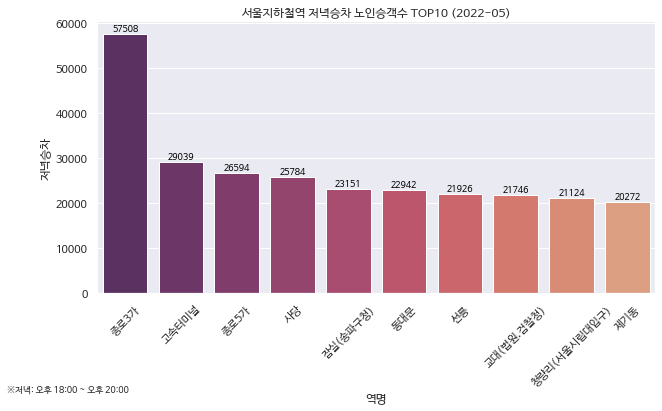

In [21]:
#저녁승차
df3_pm_on =df3_on[['역명','18시-19시','19시-20시']]
df3_pm_on['저녁승차']=df3_pm_on['18시-19시']+df3_pm_on['19시-20시']
df3_pm_on=df3_pm_on.drop(columns=['18시-19시','19시-20시'])
df3_pm_on= df3_pm_on.groupby(df3_pm_on['역명']).sum()

#아침승차 top10
df3_pm_on=(df3_pm_on
        .sort_values('저녁승차',ascending=False)
        .reset_index()
        .iloc[:10]
        )
df3_pm_on['저녁승차']=df3_pm_on['저녁승차'].astype(int)

#시각화
sns.set(rc={"figure.figsize":(10, 5)})
plt.rc('font', family='NanumBarunGothic')
x=df3_pm_on['역명']
y=df3_pm_on['저녁승차']

#색상선택
palette = sns.color_palette("flare",n_colors=10)
palette.reverse() 
p=sns.barplot(x=x,y=y,data=df3_pm_on,palette=palette).set(title='서울지하철역 저녁승차 노인승객수 TOP10 (2022-05)')
plt.figtext(0, -0.15, '※저녁: 오후 18:00 ~ 오후 20:00', fontSize=9)
#텍스트 회전
plt.xticks(rotation=45)
#수치값 표시
for i, v in enumerate(df3_pm_on.index):
    plt.text(v, y[i], y[i],                
             fontsize = 9, 
             color='black',
             horizontalalignment='center', 
             verticalalignment='bottom')
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


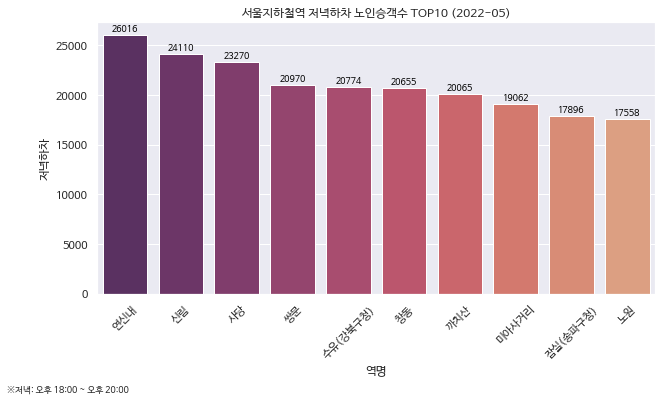

In [22]:
#저녁하차
df3_pm_off =df3_off[['역명','18시-19시','19시-20시']]
df3_pm_off['저녁하차']=df3_pm_off['18시-19시']+df3_pm_off['19시-20시']
df3_pm_off=df3_pm_off.drop(columns=['18시-19시','19시-20시'])
df3_pm_off= df3_pm_off.groupby(df3_pm_off['역명']).sum()

#저녁하차 top10
df3_pm_off=(df3_pm_off
        .sort_values('저녁하차',ascending=False)
        .reset_index()
        .iloc[:10]
        )
df3_pm_off['저녁하차']=df3_pm_off['저녁하차'].astype(int)

#시각화
sns.set(rc={"figure.figsize":(10, 5)})
plt.rc('font', family='NanumBarunGothic')
x=df3_pm_off['역명']
y=df3_pm_off['저녁하차']

#색상선택
palette = sns.color_palette("flare",n_colors=10)
palette.reverse() 
p=sns.barplot(x=x,y=y,data=df3_pm_off,palette=palette).set(title='서울지하철역 저녁하차 노인승객수 TOP10 (2022-05)')
plt.figtext(0, -0.15, '※저녁: 오후 18:00 ~ 오후 20:00', fontSize=9)
#텍스트회전
plt.xticks(rotation=45)


#수치값 표시
for i, v in enumerate(df3_pm_off.index):
    plt.text(v, y[i], y[i],                
             fontsize = 9, 
             color='black',
             horizontalalignment='center', 
             verticalalignment='bottom')
plt.show()

####우대권 사용 Top10

In [ ]:
df4=pd.read_csv('/content/drive/MyDrive/DACON6/지하철 이용 정보/서울교통공사_권종별 승차인원_20220531.csv',encoding='cp949')
df4.head()

In [ ]:
df4=(df4[['역명','5월우대권']]
    .sort_values('5월우대권',ascending=False)
    .reset_index(drop=True)
    .iloc[:10]
    )

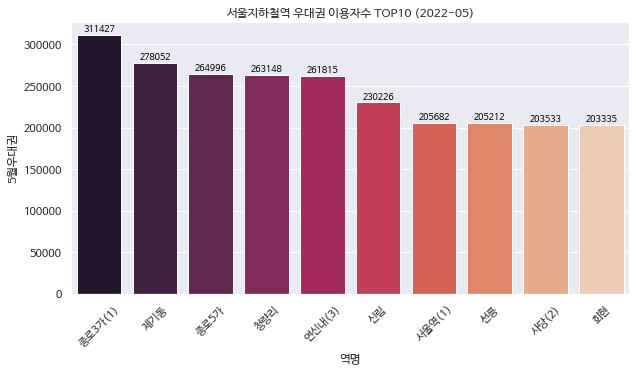

In [25]:
sns.set(rc={"figure.figsize":(10, 5)})
plt.rc('font', family='NanumBarunGothic')
palette = sns.color_palette("rocket",n_colors=10)
# palette.reverse() 
x=df4['역명']
y=df4['5월우대권']
sns.barplot(x=x,y=y,palette=palette).set(title='서울지하철역 우대권 이용자수 TOP10 (2022-05)')
#텍스트 회전
plt.xticks(rotation=45)
#수치값 표시
for i, v in enumerate(df4.index):
    plt.text(v, y[i], y[i],                
             fontsize = 9, 
             color='black',
             horizontalalignment='center', 
             verticalalignment='bottom')

plt.show()

###2. 서울대중교통 이용패턴 분석

In [26]:
#2021.11.30~2022.09.22 목적통행_패턴
df=pd.read_csv('/content/drive/MyDrive/DACON6/지하철 이용 정보/서울시 대중교통 이용패턴 정보.csv',encoding='cp949')

In [27]:
#목적통행_패턴 기준으로 합침
pattern=df.drop(columns=['기준_날짜'])
pattern=pattern.groupby(df['목적통행_패턴']).sum() 
pattern.reset_index(level=['목적통행_패턴'], inplace = True)

In [ ]:
#목적통행_패턴 총 승객수 top15
pattern_total=(pattern[['목적통행_패턴','총_승객수']]
                .sort_values('총_승객수',ascending=False)
                .reset_index(drop=True)
                .iloc[:15]
                )

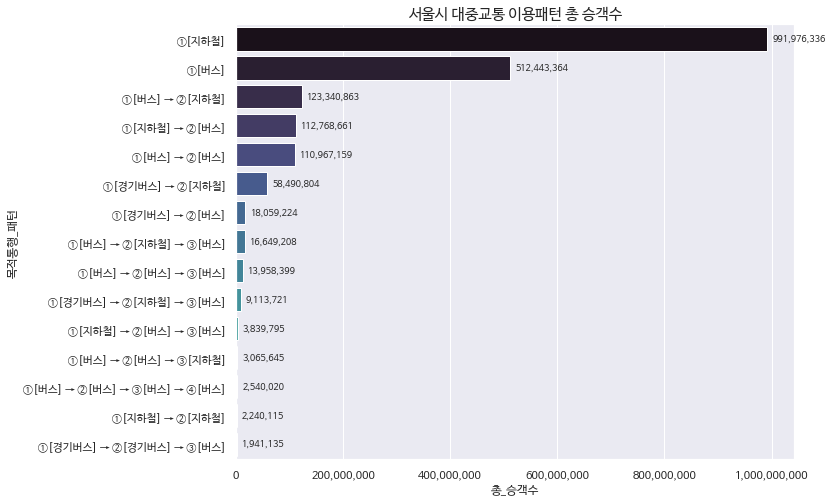

In [29]:
sns.set(rc={"figure.figsize":(10, 8)})
plt.rc('font', family='NanumBarunGothic') 
x=pattern_total['총_승객수']
y=pattern_total['목적통행_패턴']
ax=sns.barplot(x=x,y=y,palette="mako",data=pattern_total,orient='h')
ax.set_title('서울시 대중교통 이용패턴 총 승객수',fontsize=15)
#수치값 표시
for p in ax.patches:
    ax.annotate('{:,.0f}'.format(p.get_width()), (p.get_x() + p.get_width(), p.get_y() + 0.8),fontsize=9,
                xytext=(5, 10), textcoords='offset points')
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values]) 
plt.show()

In [ ]:
#목적통행_패턴 일반 승객수 top15
pattern_regular=(pattern[['목적통행_패턴','총_승객수_일반']]
                .sort_values('총_승객수_일반',ascending=False)
                .reset_index(drop=True)
                .iloc[:15]
                )
pattern_regular['총_승객수_일반']=pattern_regular['총_승객수_일반'].astype(int)             

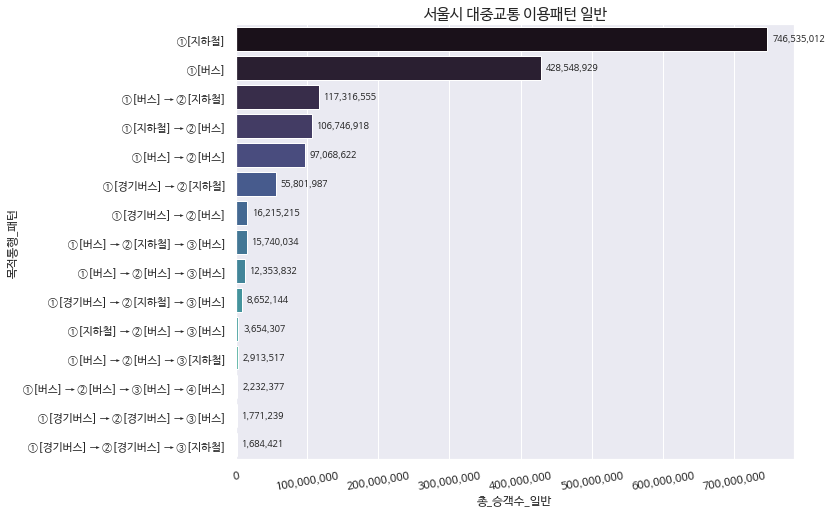

In [31]:
sns.set(rc={"figure.figsize":(10, 8)})
plt.rc('font', family='NanumBarunGothic') 
x=pattern_regular['총_승객수_일반']
y=pattern_regular['목적통행_패턴']
ax=sns.barplot(x=x,y=y,palette="mako",data=pattern_regular,orient='h')
ax.set_title('서울시 대중교통 이용패턴 일반',fontsize=15)
# 수치값 표시
for p in ax.patches:
    ax.annotate('{:,.0f}'.format(p.get_width()), (p.get_x() + p.get_width(), p.get_y() + 0.8),fontsize=9,
                xytext=(5, 10), textcoords='offset points')
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])
#텍스트 회전
plt.xticks(rotation=10) 
plt.show()

In [ ]:
#목적통행_패턴 노인 승객수 top15
pattern_senior=(pattern[['목적통행_패턴','총_승객수_경로']]
                .sort_values('총_승객수_경로',ascending=False)
                .reset_index(drop=True)
                .iloc[:15]
                )
pattern_senior['총_승객수_경로']=pattern_senior['총_승객수_경로'].astype(int) 

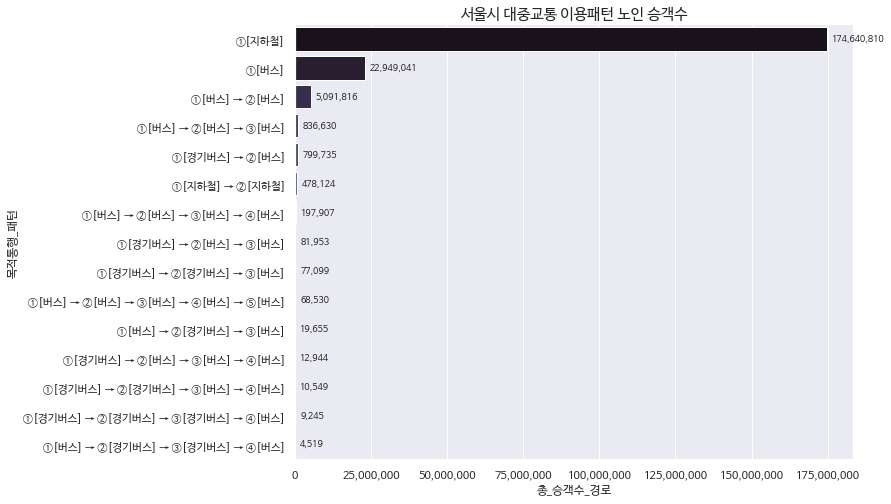

In [33]:
sns.set(rc={"figure.figsize":(10, 8)})
plt.rc('font', family='NanumBarunGothic') 
x=pattern_senior['총_승객수_경로']
y=pattern_senior['목적통행_패턴']
ax=sns.barplot(x=x,y=y,palette="mako",data=pattern_senior,orient='h')
ax.set_title('서울시 대중교통 이용패턴 노인 승객수',fontsize=15)
# 수치값 표시
for p in ax.patches:
    ax.annotate('{:,.0f}'.format(p.get_width()), (p.get_x() + p.get_width(), p.get_y() + 0.8),fontsize=9,
                xytext=(5, 10), textcoords='offset points')
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values]) 

plt.show()